#  Testing the final model on multiple time periods

See how well the model performs on more recent data

In [1]:
import os

import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import contextily as cx
import pandas as pd
from datetime import timedelta
#from eli5.sklearn import PermutationImportance
import joblib

from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, mean_squared_error

api = "6c2695a3-768a-4885-a408-5770a99f5269"

from Functions import *

/opt/homebrew/anaconda3/envs/py310/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


In [2]:
buffer_size_m=400

## Load the fitted model

In [3]:
rf_model_pipeline1 = joblib.load('Results/FinalModels/rf_model_pipeline1_{}_outlierremovaleachsensor.pkl'.format(buffer_size_m))
# rf_model_pipeline2 = joblib.load('Results/FinalModels/rf_model_pipeline2_{}.pkl'.format(buffer_size_m))
# rf_model_pipeline3 = joblib.load('Results/rf_model_pipeline3_combined_features.fit.sav')

## Load the data to test the model

In [4]:
# Need an amended prepare_x_y_data function that retains the datetime column so we can work out
# the indices for data in 2022. The original is in the Functions.py file
def prepare_x_y_data2(input_csv):
    # Read in formatted data
    data = pd.read_csv(input_csv, index_col = False)
    data = data.fillna(0)

    # Drop unneeded (mostly string) columns
    data = drop_unneeded_columns(data)

    # Get rid of columns in which none of the sensors have a value
    for column in data.columns:
        if np.nanmax(data[column]) ==0:
            del data[column]

    # Filter columns using the regex pattern in function input
    regex_pattern = 'buildings$|street_inf$|landmarks$'
    data = data[data.columns.drop(list(data.filter(regex=regex_pattern)))].copy()

    ### Add a random variable (to compare performance of other variables against)
    rng = np.random.RandomState(seed=42)
    data['random'] = np.random.random(size=len(data))
    data["random_cat"] = rng.randint(3, size=data.shape[0])

    ## Prepare data for modelling
    ### Split into predictor/predictand variables
    Xfull = data.drop(['hourly_counts'], axis =1)
    Yfull = data['hourly_counts'].values

    ### Store the (non Sin/Cos) time columns and then remove them (Need them later to segment the results by hour of the day)
    data_time_columns = Xfull[['day_of_month_num', 'time', 'weekday_num', 'time_of_day', 'datetime']]
    Xfull = Xfull.drop(['day_of_month_num', 'time', 'weekday_num', 'time_of_day','month_num'],axis=1)
    # (Note: have kept datetime column!

    return Xfull, Yfull, data_time_columns

In [5]:
input_csv = "../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}_outlierremovaleachsensor.csv".format(buffer_size_m)
_Xfull, _Yfull, _data_time_columns = prepare_x_y_data2(input_csv)

# (NOTE: underscores are to denote global variables that should not be
# confused with model-specific ones later)

temp = pd.read_csv(input_csv)
_datetimes = temp['datetime']
_sensor_ids = temp['sensor_id']
del temp

/var/folders/bx/3j5z8qc50wl1tcff6xvbf2zh0000gs/T/ipykernel_50894/1462808028.py:5: DtypeWarning: Columns (4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(input_csv, index_col = False)
/var/folders/bx/3j5z8qc50wl1tcff6xvbf2zh0000gs/T/ipykernel_50894/436144243.py:7: DtypeWarning: Columns (4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(input_csv)


## Create data slices for different time periods


Split the data into a few different time periods

In [6]:
time_periods = [
    ("Pre-COVID", '2020-01-01', '2020-03-01'),
    ("During COVID (early 2020)", '2020-03-01', '2020-06-01'),
    ("During COVID (late 2020)", '2020-07-01', '2021-01-01'),
    ("During COVID (2021)", '2021-01-01', '2022-01-01'),
    ("Post-COVID (2022)", '2022-01-01', '2023-01-01'),
    ("Post-COVID (2023)", '2023-01-01', '2024-01-01'),
    ("Post-COVID (2024)", '2024-01-01', '2024-07-01'),
]

## Run the final model on those different time periods

I'm going to use a class to keep the results and data organised.


In [7]:
from typing import ClassVar
from dataclasses import dataclass, field

@dataclass
class Model():

    # Required arguments
    name: str
    Xfull: pd.DataFrame
    Yfull: np.ndarray
    datetimes: pd.Series
    sensor_ids: pd.Series

    # We calculate the following post-init; they are related to overall model performance;
    y_pred: np.ndarray = None
    mae_score: float = None
    r2_score: float = None
    rmse_score: float = None
    neg_mae_score: float = None

    # These are for measuring the performance by sensor and calculated later
    # (could probably replace Xfull and Yfull etc above with this but I haven't tried)
    # Note that the 'field' is needed because of dataclasses otherwise share lists across objects
    df: pd.DataFrame = None  # Dataframe for sensor/hours
    sensorly_mapes: list = field(default_factory=list)
    sensorly_maes: list = field(default_factory=list)
    sensorly_means: list = field(default_factory=list)
    sensorly_errors_df: pd.DataFrame = None  # Duplicates lists above (probably unnecessary)

    # Class variable
    rf_model_pipeline: ClassVar[Pipeline] = joblib.load(
        'Results/FinalModels/rf_model_pipeline1_{}_outlierremovaleachsensor.pkl'
        .format(buffer_size_m))

    def __post_init__(self):
        assert len(self.Xfull) == len(self.Yfull) == len(self.datetimes) == len(self.sensor_ids)
        print(f"Running predictions for {self.name}")
        #self.Xfull.drop(columns=['day', 'datetime', 'year'])
        self.y_pred = Model.rf_model_pipeline.predict(self.Xfull)
        self.calc_errors()

    def calc_errors(self):
        self.mae_score = mean_absolute_error(self.Yfull, self.y_pred)
        self.r2_score = r2_score(self.Yfull, self.y_pred)
        self.rmse_score = mean_squared_error(self.Yfull, self.y_pred, squared=False)
        self.neg_mae_score = -1 * self.mae_score

    def print_scores(self):
        print(f"Scores for model '{self.name}'")
        print(f"\tMean absoloute error: {self.mae_score}")
        print(f"\tMean R2: {self.r2_score}")
        print(f"\tMean RMSE: {self.rmse_score}")

    def get_time_period_as_str(self):
        """Get a tuple of start and end time periods as strings.
        Add one day to the end period so that it is *exclusive* not inclusive"""
        return (pd.to_datetime(self.datetimes.min()).strftime('%Y-%m'),
                (pd.to_datetime(self.datetimes.max()) + timedelta(days=1)).strftime('%Y-%m'))


# Store the models in a list
models = []

for (name, start, end) in time_periods:
    # Create the stuff needed for the model class
    time_indices = _Xfull.index[
        (pd.to_datetime(_Xfull['datetime']) >= start) &
        (pd.to_datetime(_Xfull['datetime']) < end)]

    m = Model(
        name=name,
        Xfull = _Xfull.iloc[time_indices].drop(
            columns=['day', 'datetime', 'year']).copy(),
        Yfull = _Yfull[time_indices].copy(),
        datetimes = _datetimes.iloc[time_indices].copy(),
        sensor_ids = _sensor_ids.iloc[time_indices].copy()
    )
    models.append(m)


Running predictions for Pre-COVID
Running predictions for During COVID (early 2020)
Running predictions for During COVID (late 2020)
Running predictions for During COVID (2021)
Running predictions for Post-COVID (2022)
Running predictions for Post-COVID (2023)
Running predictions for Post-COVID (2024)


Make a table to show the results

In [8]:
#for m in models:
#    m.print_scores()

results = None
for i, m in enumerate(models):
    start, end = m.get_time_period_as_str()
    new_result = pd.DataFrame({
        "Time Period": [m.name],
        "Start": [start],
        "End": [end],
        "MAE": [m.mae_score],
        "RMSE": [m.rmse_score],
        "R^2": [m.r2_score],
    })
    if i==0:
        results = new_result
    else:
        results = pd.concat([results, new_result])


In [9]:
results

,Time Period,Start,End,MAE,RMSE,R^2
0,Pre-COVID,2020-01,2020-03,146.300055,280.744427,0.856762
0,During COVID (early 2020),2020-03,2020-06,415.138663,719.306965,-2.519992
0,During COVID (late 2020),2020-07,2021-01,477.364695,801.858798,-7.035489
0,During COVID (2021),2021-01,2022-01,407.479686,722.439643,-2.606864
0,Post-COVID (2022),2022-01,2023-01,306.591231,584.797648,-0.230091
0,Post-COVID (2023),2023-01,2024-01,279.326860,539.789204,0.190430
0,Post-COVID (2024),2024-01,2024-07,293.676576,546.205265,0.082353


In latex (with all number to 3SF)

In [10]:
print(results.applymap(lambda x: f"{x:.3g}" if isinstance(x, (int, float)) else x).to_latex(index=False))

\begin{tabular}{llllll}
\toprule
Time Period & Start & End & MAE & RMSE & R^2 \\
\midrule
Pre-COVID & 2020-01 & 2020-03 & 146 & 281 & 0.857 \\
During COVID (early 2020) & 2020-03 & 2020-06 & 415 & 719 & -2.52 \\
During COVID (late 2020) & 2020-07 & 2021-01 & 477 & 802 & -7.04 \\
During COVID (2021) & 2021-01 & 2022-01 & 407 & 722 & -2.61 \\
Post-COVID (2022) & 2022-01 & 2023-01 & 307 & 585 & -0.23 \\
Post-COVID (2023) & 2023-01 & 2024-01 & 279 & 540 & 0.19 \\
Post-COVID (2024) & 2024-01 & 2024-07 & 294 & 546 & 0.0824 \\
\bottomrule
\end{tabular}



## Show how the error varies with line charts

In [11]:
results_dir = os.path.join("Results", "ModelTestPostCovid/")
os.makedirs(results_dir, exist_ok=True)

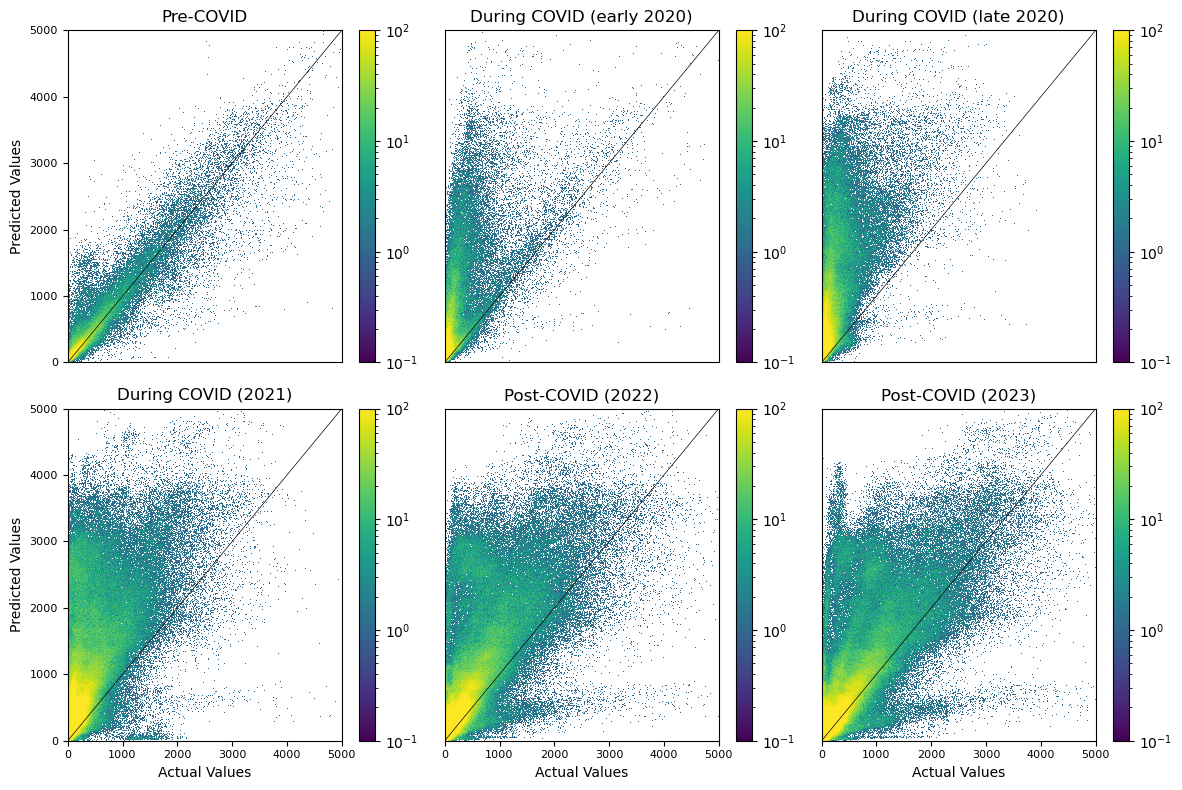

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

xmax = 5000
ymax = 5000
assert xmax == ymax # Need to be symmetrical for chart

for i, (m, ax) in enumerate(zip(models, axes)):
    # Plot with log scale
    using_datashader(ax, m.Yfull, m.y_pred, 'log')
    # Add diagonal line
    ax.plot([0, ymax], [0, xmax], c='k', lw=0.5)
    ax.set_title(m.name)

    # Only set x and y labels for bottom-left plots
    if i % 3 == 0:  # First column gets y-labels
        ax.set_ylabel("Predicted Values", size=10)
    else:  # Hide y-ticks for other columns
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)

    if i >= 3:  # Last row gets x-labels
        ax.set_xlabel("Actual Values", size=10)
    else:  # Hide x-ticks for other rows
        ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

    ax.set_xlim([0, xmax])
    ax.set_ylim([0, ymax])
    ax.tick_params(axis='both', which='major', labelsize=8)

fig.tight_layout()
fig.savefig(os.path.join(results_dir, "Predicted_vs_actual_values_log_multiple_time_periods.png"),
            bbox_inches='tight')

## Show how the error varies spatially by sensor

In [13]:
# For calculating the mean percentage error
def MAPE(Y_actual,Y_Predicted):
    # NM added this - if the predicted or actual values are 0 then it is dangerous to
    # calculate a percentage (either divide by 0 or misleading) so just return 0.
    if Y_actual == 0 or Y_Predicted == 0:
        return 0
    try:
        mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    except:
        mape = np.nan
    return mape

In [14]:
for i, m in enumerate(models):
    print(f"Calculating error by sensor for model {i} ({m.name}).")
    # Get all relevant data in one dataframe
    df = pd.DataFrame({'Predictions': m.y_pred, 'Real_vals':m.Yfull,
                       #'Hour': m.data_time_columns['time'], 'Weekday': m.data_time_columns['weekday_num'],
                       'sensor_id': m.sensor_ids,
                       'AbsolouteError':abs(m.Yfull - m.y_pred),
                       'Error':m.Yfull-m.y_pred,
                       'datetime':pd.to_datetime(m.datetimes, errors="coerce"),
                       })

    df['Percentage_Difference']= abs(df['Real_vals'] - df['Predictions'])/((df['Real_vals'] + df['Predictions'])/2)* 100
    df['Percentage_Increase']= ((df['Real_vals'] - df['Predictions']) / abs(df['Predictions'])) * 100
    #df["datetime"]  =
    df['Mape']  = df.apply(lambda x: MAPE(x['Real_vals'], x['Predictions']), axis=1)

    # Loop through the sensors, calculate mean errors, and add the results to the lists for this model
    for sensor_id in np.sort(m.sensor_ids.unique()):
        # print("At sensor {}".format(sensor_id))
        one_sensor = df[df['sensor_id'] ==sensor_id]
        # print("Error is {}% of the average hourly count".format(round(one_sensor['AbsolouteError'].mean()/one_sensor['Real_vals'].mean()*100,1)))
        m.sensorly_mapes.append(round(one_sensor['AbsolouteError'].mean()/one_sensor['Real_vals'].mean()*100,1))
        m.sensorly_maes.append(round(one_sensor['AbsolouteError'].mean(),1))
        m.sensorly_means.append(one_sensor['Real_vals'].mean())

    assert len(m.sensor_ids.unique()) == len(m.sensorly_mapes) == len(m.sensorly_maes) == len(m.sensorly_means),\
        f"Lenghts differ for {m.name}: {len(m.sensor_ids.unique())}, {len(m.sensorly_mapes)}, {len(m.sensorly_maes)}, {len(m.sensorly_means)}"
    # Also keep the df as we need it later
    m.df = df

Calculating error by sensor for model 0 (Pre-COVID).
Calculating error by sensor for model 1 (During COVID (early 2020)).
Calculating error by sensor for model 2 (During COVID (late 2020)).
Calculating error by sensor for model 3 (During COVID (2021)).
Calculating error by sensor for model 4 (Post-COVID (2022)).
Calculating error by sensor for model 5 (Post-COVID (2023)).
Calculating error by sensor for model 6 (Post-COVID (2024)).


Histograms of the error (mostly for checking)

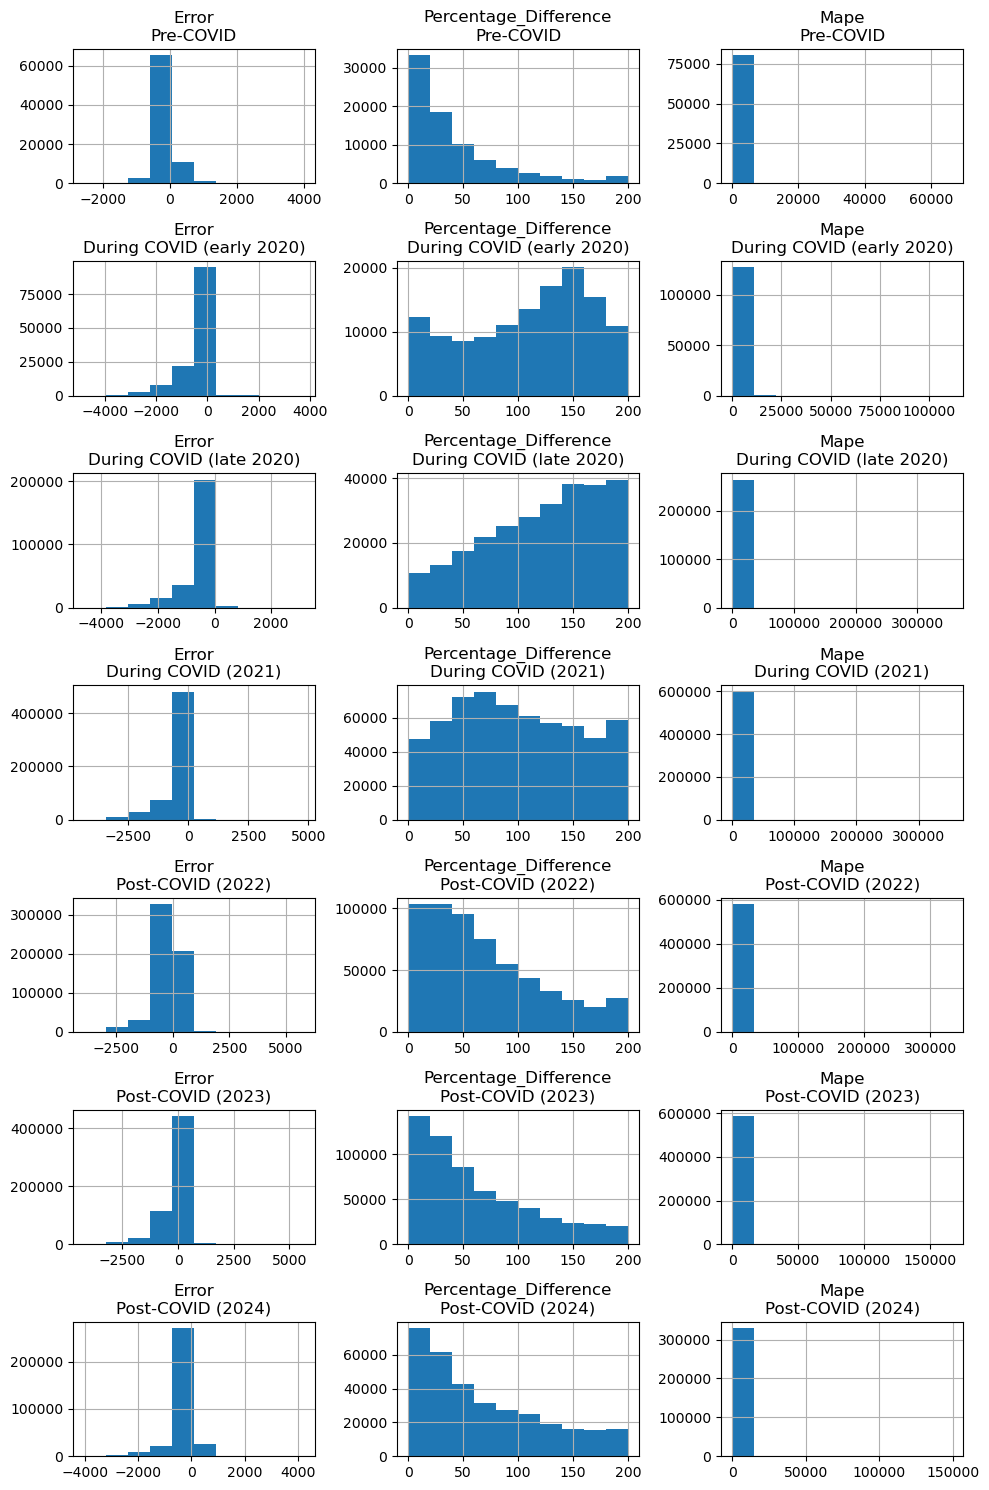

In [15]:
fig, axes = plt.subplots(nrows=len(models), ncols=3, figsize=(10, 15))
for i, error in enumerate(['Error', 'Percentage_Difference', 'Mape']):
    for j, m in enumerate(models):
        ax =axes[j][i]
        m.df[error].hist(ax=ax)
        ax.set_title(f"{error}\n{m.name}")
fig.tight_layout()


**Now map the errors by sensor**

First create the geodataframe for each model

In [16]:
### Read in Melbourne sensor location spatial data
_melbourne_sensors = pd.read_csv("../Cleaned_data/SensorData/sensor_locations.csv")
_melbourne_sensors.rename(columns={'sensor_description': 'Name'}, inplace = True)

for m in models:
    m.sensorly_errors_df = pd.DataFrame({'sensor_id':np.sort(m.sensor_ids.unique()),
                                         'MAPE':m.sensorly_mapes,'MAE':m.sensorly_maes, 'Mean':m.sensorly_means})
    m.sensorly_errors_df.dropna(inplace=True)
    m.melbourne_sensors = pd.merge(m.sensorly_errors_df, _melbourne_sensors, on='sensor_id', how='left')

    geometry = [Point(xy) for xy in zip(m.melbourne_sensors.Longitude, m.melbourne_sensors.Latitude)]
    m.gdf = gpd.GeoDataFrame(m.melbourne_sensors, geometry=geometry)
    m.gdf = m.gdf.set_crs('EPSG:4326')
    m.gdf = m.gdf.to_crs('epsg:3857')


Now map them (currently using logged MAPE)

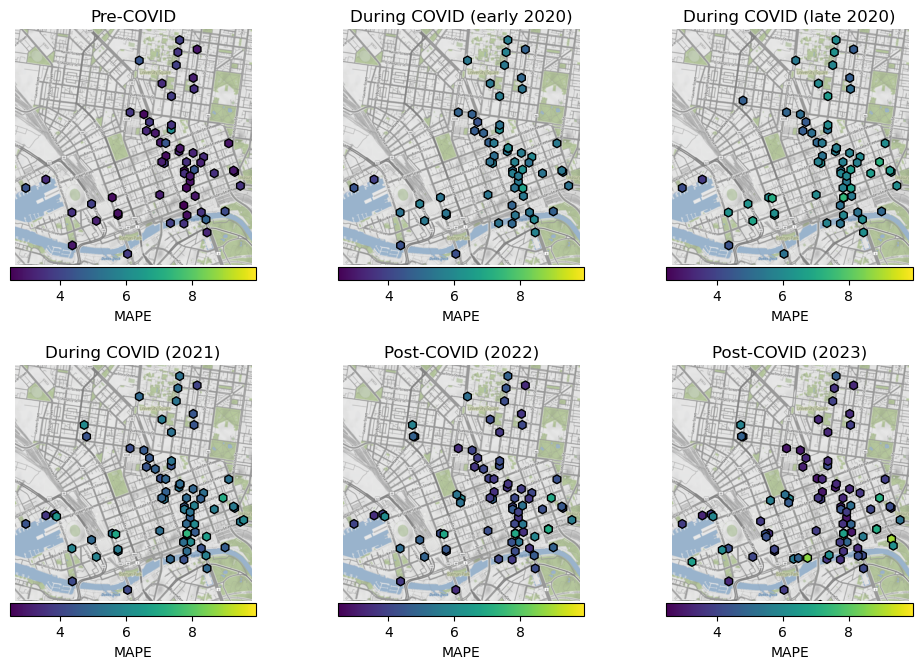

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()
#error = "Mean"
error = "MAPE"
#error = "MAE"
vmin = min(np.log(m.gdf[error].min()) for m in models)
vmax = max(np.log(m.gdf[error].max()) for m in models)


for i, (m, ax) in enumerate(zip(models, axes)):

  m.gdf.plot(ax=ax, column=np.log(m.gdf[error]), markersize = 40, edgecolor = 'black',
             cmap="viridis", marker='h', legend = True,
             legend_kwds={'shrink': 0.9, 'pad':0.01, 'label':error,
                      "orientation": "horizontal"},
             vmin = vmin,
             vmax = vmax
             )
  # Change font size on legend
  ax.tick_params(labelsize=30)
  ax.set_title(m.name)

  # Add basemaps
  cx.add_basemap(ax, source='https://tiles.stadiamaps.com/tiles/stamen_terrain/{z}/{x}/{y}{r}.png?api_key='+api)
  ax.axis('off')
  ax.set_axis_off()

fig.savefig(os.path.join(results_dir, "SpatialErrors-MAPE-log_multiple_time_periods.png"), bbox_inches='tight')
